### EMOVOICE: Real-time Speech Emotion Recognition Using Raw Audio Features and Deep Learning

### Importing Data

In [1]:
%pip install kagglehub
%pip install torchaudio librosa numpy torch noisereduce
%pip install librosa


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import kagglehub
import torchaudio as ta
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader
import os
import torch as t
import numpy as np
import librosa
import noisereduce as nr
from typing import Optional, Callable

In [3]:
# Download latest version
path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")
print("Path to dataset files:", path)

Path to dataset files: /Users/tiana/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1


In [4]:
class SpeechDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.filelist = []
        for root, dirs, files in os.walk(self.root_dir):
            for name in files:
                self.filelist.append(os.path.join(root, name))
        self.filelist = np.array(self.filelist)


    def __len__(self):
        return len(self.filelist)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        path = os.path.join(self.root_dir, self.filelist[idx])
        
        label = os.path.basename(path)
        
        mod, chan, emo, inten, state, repit, act = str(label).split("-")
        audio, _ = ta.load(path)
        emotiontensor = nn.functional.one_hot(t.tensor(int(emo)))

        if self.transform:
            audio = self.transform(audio)

        return audio, emotiontensor

In [ ]:
from transformers import Wav2Vec2Model

model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-large-960h-lv60-self", torch_dtype=t.float16, attn_implementation="flash_attention_2").to(device)

In [ ]:
from transformers import AutoFeatureExtractor


class Pipeline(nn.Module):
    def __init__(self, rate):
        self.feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-base")
        self.resample = Resample(orig_freq=input_freq, new_freq=self.feature_extractor.sampling_rate)

        
    def forward(self, tensor):
        
        tensor = self.resample(tensor)
        tensor = self.feature_extractor(
        tensor, sampling_rate=feature_extractor.sampling_rate, max_length=16000, truncation=True)
        
        return tensor 

In [ ]:
Data = SpeechDataset(path, None)
rate = ta.load(Data.filelist[0])

pipe = Pipeline(rate)
Data.transform = pipe
trainset, testset = torch.utils.data.random_split(Data, [0.85, 0.15])

### Training

In [ ]:
trainset = t.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)
testset = t.utils.data.DataLoader(testset, batch_size=10, shuffle=True)

In [ ]:
from transformers import AutoModelForAudioClassification, TrainingArguments, Trainer

num_labels = len(id2label)
model = AutoModelForAudioClassification.from_pretrained(
    "facebook/wav2vec2-base", num_labels=num_labels, label2id=label2id, id2label=id2label
)

In [ ]:
training_args = TrainingArguments(
    output_dir="model_data",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=32,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_minds["train"],
    eval_dataset=encoded_minds["test"],
    processing_class=feature_extractor,
    compute_metrics=compute_metrics,
)

trainer.train()

### Tiana shi

In [5]:
class SpeechDataset(Dataset):
    """Custom dataset for speech emotion recognition with real-time processing capabilities."""

    def __init__(self, 
                 root_dir: str, 
                 segment_length: int = 3,  # seconds
                 sample_rate: int = 16000,
                 transform: Optional[Callable] = None,
                 noise_reduce: bool = True,
                 use_dual_input: bool = True):
        """
        Args:
            root_dir: Directory with audio files
            segment_length: Length of audio segments in seconds (1-3s as per proposal)
            sample_rate: Target sample rate for audio
            transform: Optional transform to be applied
            noise_reduce: Whether to apply noise reduction
            use_dual_input: Whether to return both waveform and spectrogram
        """
        self.root_dir = root_dir
        self.transform = transform
        self.segment_length = segment_length
        self.sample_rate = sample_rate
        self.noise_reduce = noise_reduce
        self.use_dual_input = use_dual_input
        
        # Initialize spectrogram converter
        self.mel_spectrogram = T.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=1024,
            hop_length=512,
            n_mels=64
        )
        
        # Get file list
        self.filelist = []
        for root, _, files in os.walk(self.root_dir):
            for file in files:
                if file.endswith('.wav'):
                    self.filelist.append(os.path.join(root, file))

    def __len__(self):
        return len(self.filelist)

    def _load_and_process_audio(self, path: str):
        """Load audio file and apply preprocessing"""
        # Load audio
        waveform, orig_sr = ta.load(path)
        
        # Resample if needed
        if orig_sr != self.sample_rate:
            resampler = T.Resample(orig_sr, self.sample_rate)
            waveform = resampler(waveform)
        
        # Convert to mono if stereo
        if waveform.shape[0] > 1:
            waveform = t.mean(waveform, dim=0, keepdim=True)
        
        # Noise reduction (spectral gating as per proposal)
        if self.noise_reduce:
            waveform_np = waveform.numpy()[0]
            reduced_noise = nr.reduce_noise(
                y=waveform_np, 
                sr=self.sample_rate,
                stationary=True
            )
            waveform = t.from_numpy(reduced_noise).unsqueeze(0)
        
        # Normalize
        waveform = waveform / (t.max(t.abs(waveform)) + 1e-8)
        
        # Segment into fixed-length chunks (for real-time processing)
        num_samples = int(self.segment_length * self.sample_rate)
        if waveform.shape[1] > num_samples:
            # Random crop for training
            start = np.random.randint(0, waveform.shape[1] - num_samples)
            waveform = waveform[:, start:start+num_samples]
        elif waveform.shape[1] < num_samples:
            # Pad with zeros if too short
            padding = num_samples - waveform.shape[1]
            waveform = t.nn.functional.pad(waveform, (0, padding))
        
        return waveform
    
    def _extract_features(self, waveform):
        """Extract features including log-mel spectrograms"""
        # Compute log-mel spectrogram
        spectrogram = self.mel_spectrogram(waveform)

        # Add small offset before dB conversion
        spectrogram = T.AmplitudeToDB()(spectrogram + 1e-10)

        # Clip extreme values
        spectrogram = t.clamp(spectrogram, min=-80, max=0)

        return spectrogram

    def __getitem__(self, idx):
        if t.is_tensor(idx):
            idx = idx.tolist()
        
        path = self.filelist[idx]
        
        # Extract emotion label from filename (RAVDESS format)
        filename = os.path.basename(path)
        parts = filename.split("-")
        if len(parts) >= 3:  # Ensure have enough parts
            emo = parts[2]
            emotion = t.tensor(int(emo)-1)  # Convert to 0-based index
        else:
            emotion = t.tensor(0)  # Default emotion if parsing fails
        
        # Process audio
        waveform = self._load_and_process_audio(path)
        
        # Prepare sample
        if self.use_dual_input:
            spectrogram = self._extract_features(waveform)
            sample = {
                'waveform': waveform,
                'spectrogram': spectrogram,
                'emotion': emotion
            }
        else:
            sample = {'waveform': waveform, 'emotion': emotion}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

In [6]:
# Create dataset
dataset = SpeechDataset(
    root_dir=path,
    segment_length=2,  # 2-second segments
    noise_reduce=True,
    use_dual_input=True  # Both waveform and spectrogram
)

# Create dataloader, num_workers=0 for now
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)

### Visualizing

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

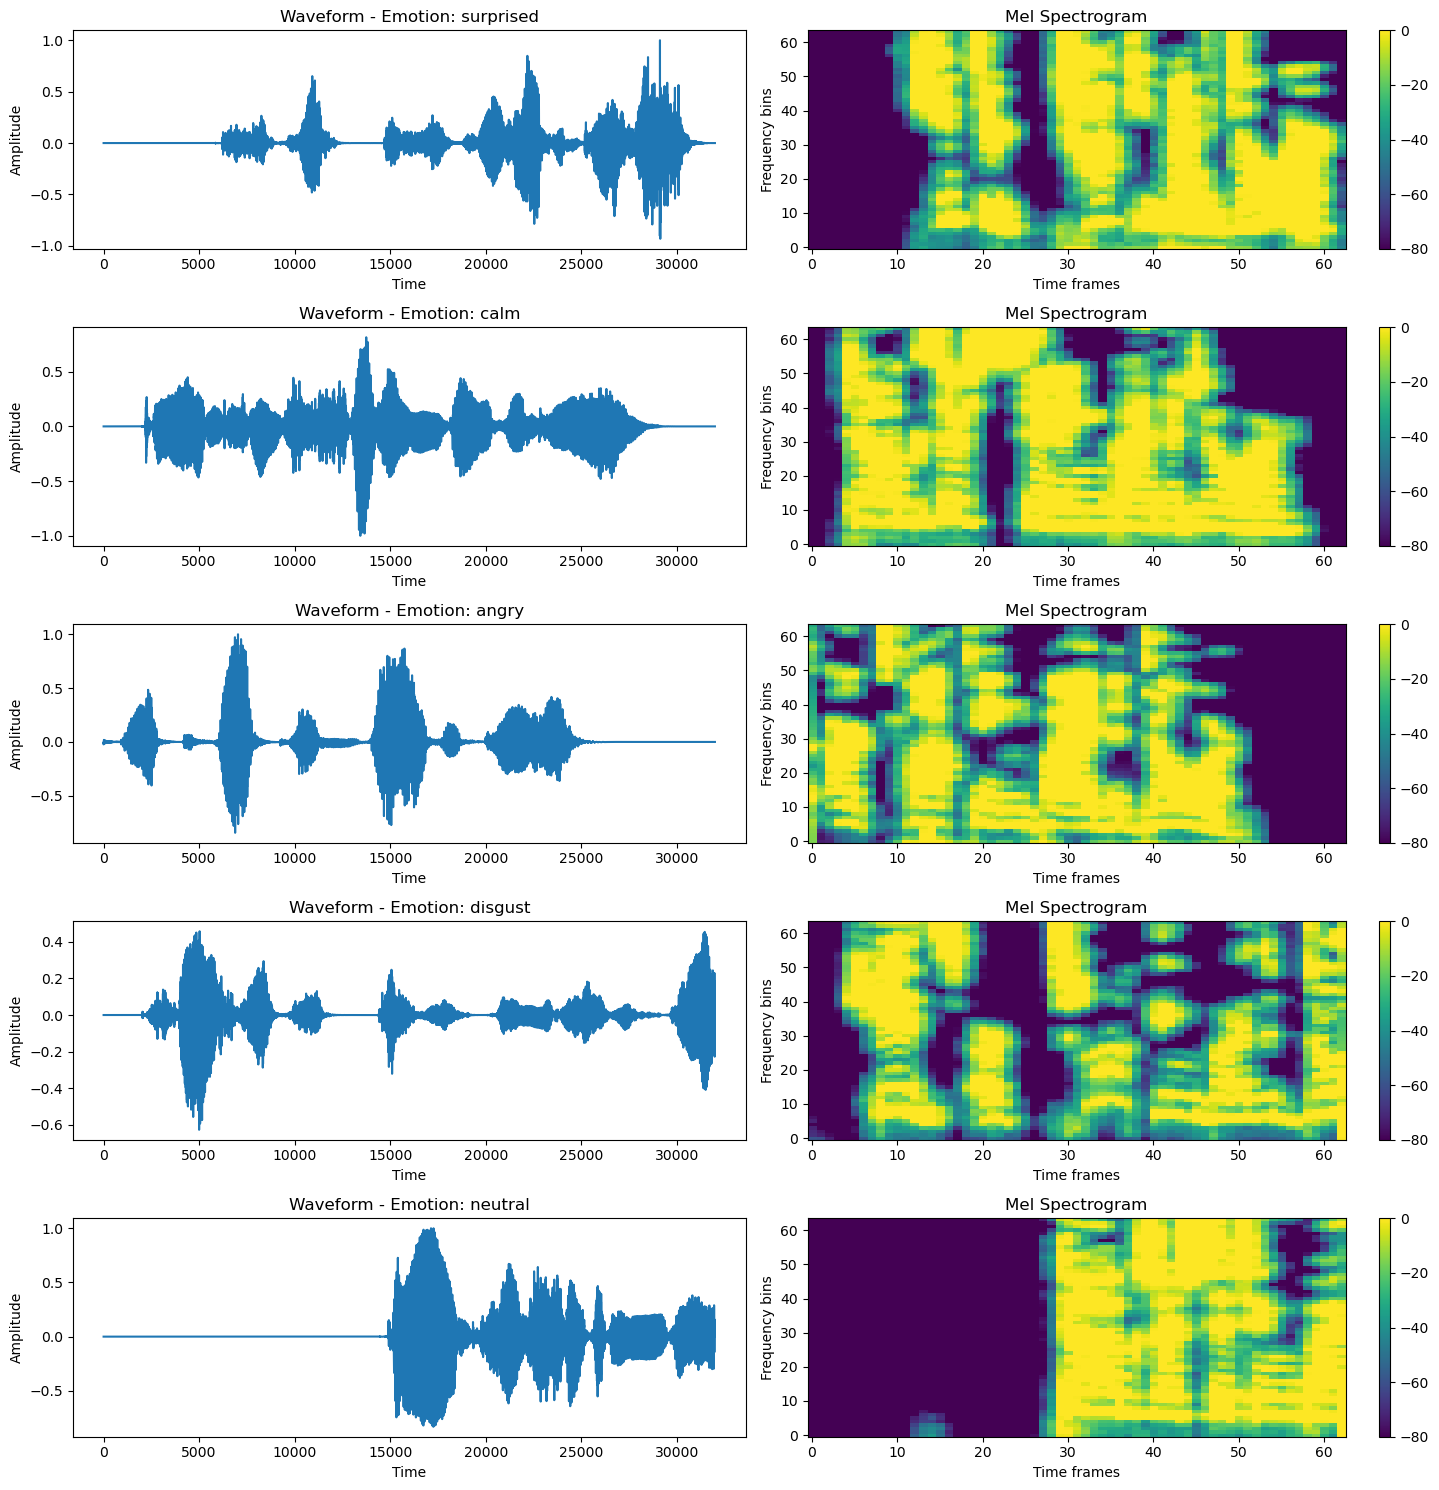

In [8]:
def visualize_samples(dataset, num_samples=5):
    """Visualize random audio samples and their spectrograms"""
    indices = np.random.choice(len(dataset), num_samples)
    emotion_map = {
        0: 'neutral', 1: 'calm', 2: 'happy', 3: 'sad',
        4: 'angry', 5: 'fearful', 6: 'disgust', 7: 'surprised'
    }
    
    plt.figure(figsize=(15, 3*num_samples))
    for i, idx in enumerate(indices):
        sample = dataset[idx]
        
        # Plot waveform
        plt.subplot(num_samples, 2, 2*i+1)
        plt.plot(sample['waveform'].squeeze().numpy())
        plt.title(f"Waveform - Emotion: {emotion_map[sample['emotion'].item()]}")
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        
        # Plot spectrogram
        plt.subplot(num_samples, 2, 2*i+2)
        plt.imshow(sample['spectrogram'].squeeze().numpy(), 
                  aspect='auto', origin='lower')
        plt.title("Mel Spectrogram")
        plt.colorbar()
        plt.xlabel('Time frames')
        plt.ylabel('Frequency bins')
    
    plt.tight_layout()
    plt.show()

visualize_samples(dataset)

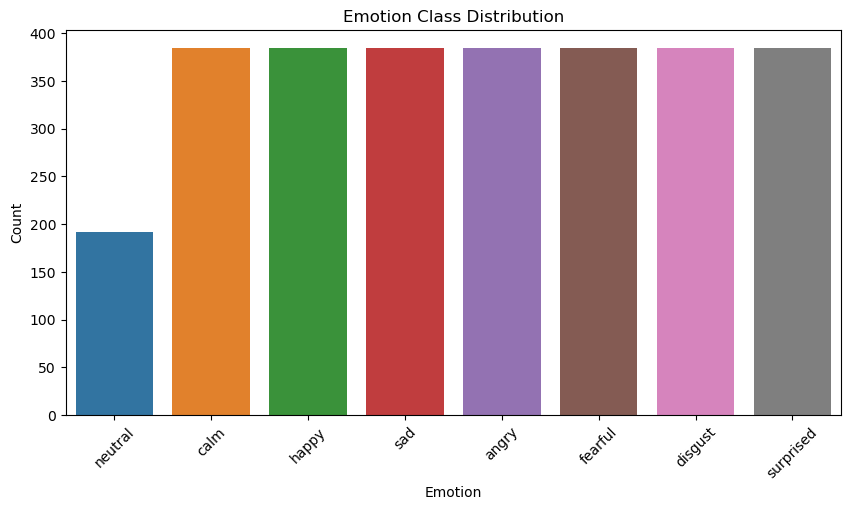

In [9]:
def plot_emotion_distribution(dataloader):
    """Plot histogram of emotion labels in the dataset"""
    all_emotions = []
    for batch in dataloader:
        all_emotions.extend(batch['emotion'].tolist())
    
    emotion_map = {
        0: 'neutral', 1: 'calm', 2: 'happy', 3: 'sad',
        4: 'angry', 5: 'fearful', 6: 'disgust', 7: 'surprised'
    }
    
    plt.figure(figsize=(10, 5))
    sns.countplot(x=all_emotions)
    plt.xticks(ticks=range(8), labels=[emotion_map[i] for i in range(8)], rotation=45)
    plt.title('Emotion Class Distribution')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.show()

plot_emotion_distribution(dataloader)

In [10]:
def compare_augmentations(dataset, idx=0):
    """Compare original and augmented samples"""
    original = dataset[idx]
    augmented = dataset[idx]  # apply transform if defined
    
    plt.figure(figsize=(12, 6))
    
    # Original waveform
    plt.subplot(2, 2, 1)
    plt.plot(original['waveform'].squeeze().numpy())
    plt.title('Original Waveform')
    
    # Original spectrogram
    plt.subplot(2, 2, 2)
    plt.imshow(original['spectrogram'].squeeze().numpy(), 
              aspect='auto', origin='lower')
    plt.title('Original Spectrogram')
    
    # Augmented waveform
    plt.subplot(2, 2, 3)
    plt.plot(augmented['waveform'].squeeze().numpy())
    plt.title('Augmented Waveform')
    
    # Augmented spectrogram
    plt.subplot(2, 2, 4)
    plt.imshow(augmented['spectrogram'].squeeze().numpy(), 
              aspect='auto', origin='lower')
    plt.title('Augmented Spectrogram')
    
    plt.tight_layout()
    plt.show()

# after add transforms

# compare_augmentations(dataset)

In [11]:
def calculate_batch_stats(dataloader):
    """Calculate mean and std of waveforms and spectrograms"""
    waveform_sum = 0
    waveform_sq_sum = 0
    spectrogram_sum = 0
    spectrogram_sq_sum = 0
    total_samples = 0
    
    for batch in dataloader:
        waveforms = batch['waveform']
        spectrograms = batch['spectrogram']
        
        waveform_sum += waveforms.sum()
        waveform_sq_sum += (waveforms**2).sum()
        
        spectrogram_sum += spectrograms.sum()
        spectrogram_sq_sum += (spectrograms**2).sum()
        
        total_samples += waveforms.size(0)
    
    waveform_mean = waveform_sum / total_samples
    waveform_std = (waveform_sq_sum / total_samples - waveform_mean**2)**0.5
    
    spectrogram_mean = spectrogram_sum / total_samples
    spectrogram_std = (spectrogram_sq_sum / total_samples - spectrogram_mean**2)**0.5
    
    print(f"Waveform - Mean: {waveform_mean:.4f}, Std: {waveform_std:.4f}")
    print(f"Spectrogram - Mean: {spectrogram_mean:.4f}, Std: {spectrogram_std:.4f}")
    
    return waveform_mean, waveform_std, spectrogram_mean, spectrogram_std

wav_mean, wav_std, spec_mean, spec_std = calculate_batch_stats(dataloader)

Waveform - Mean: 0.0041, Std: 17.5884
Spectrogram - Mean: -170891.3438, Std: nan


In [12]:
# Save these values to use in your model
stats = {
    'waveform_mean': wav_mean,
    'waveform_std': wav_std,
    'spectrogram_mean': spec_mean,
    'spectrogram_std': spec_std
}

# You can save them to a file
# import pickle
# with open('dataset_stats.pkl', 'wb') as f:
#     pickle.dump(stats, f)

In [13]:
# sample = dataset[0]
# waveform = sample['waveform']
# print("Waveform stats:")
# print(f"Min: {waveform.min().item():.4f}")
# print(f"Max: {waveform.max().item():.4f}")
# print(f"Mean: {waveform.mean().item():.4f}")
# print(f"Std: {waveform.std().item():.4f}")